# Project Overview

__Churn Prediction ML Modeling Using Apache Spark/PySpark on Sparkify Dataset__

This project aims to build a customer churn prediction model for the hypothetical music streaming service company Sparkify using the PySpark framework.

This workspace contains the exploratory data analysis, feature engineering, and modeling on a small subset (256MB) of the full dataset available (12GB). The most suitable model and hyper-parameters derived from the analysis on the small dataset will then be deployed to AWS for training the model on the full dataset.

# Import Libraries

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.ml.classification import (
    DecisionTreeClassifier,
    GBTClassifier,
    LogisticRegression,
    RandomForestClassifier,
)
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator,
)
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

%matplotlib inline
plt.style.use('seaborn-darkgrid')
sns.set(style="darkgrid")

# Create Spark Session and Load Data

In [2]:
# create spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()
spark.sparkContext.getConf().getAll()

[('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.id', 'local-1593765812039'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'mint.lan'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '34135')]

In [3]:
# load data
file_path = "./medium-sparkify-event-data.json"
df = spark.read.json(file_path)

# Data Preprocessing 

In this section, we will take a high level look at the dataset and perform necessary data cleaning to prepare the data for further exploratory analysis.

## Size

In [4]:
print(f"The data set contains {df.count()} rows and {len(df.columns)} columns of data")

The data set contains 543705 rows and 18 columns of data


## Columns

In [5]:
# display columns names
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## Descriptive Stats

In [6]:
df.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|        location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|           432877|    543705|   528005|528005|            543705|  528005|            432877|543705|          528005|543705| 543705|          

## Null Values

In [7]:
# check null values
for col in df.columns:
    print(col, "\t", "with null values:", df.filter(df[col].isNull()).count())

artist 	 with null values: 110828
auth 	 with null values: 0
firstName 	 with null values: 15700
gender 	 with null values: 15700
itemInSession 	 with null values: 0
lastName 	 with null values: 15700
length 	 with null values: 110828
level 	 with null values: 0
location 	 with null values: 15700
method 	 with null values: 0
page 	 with null values: 0
registration 	 with null values: 15700
sessionId 	 with null values: 0
song 	 with null values: 110828
status 	 with null values: 0
ts 	 with null values: 0
userAgent 	 with null values: 15700
userId 	 with null values: 0


## Exam columns with Null Values

In [8]:
# null values due to empty userId
df.select("userId","firstName","lastName", "location", "registration", "userAgent").where(F.col("firstName").isNull()).show()

+------+---------+--------+--------+------------+---------+
|userId|firstName|lastName|location|registration|userAgent|
+------+---------+--------+--------+------------+---------+
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|    

__Observation__

The null values in the `firstName`, `lastName`, `location`, `registration`, and `userAgent` columns correspond to `userId` of empty strings. We can assume that these event records are belong to non-registered users. Thus, these rows should be removed from the analysis.

In [9]:
# null values due to activities (page visited) not related to song playing 
df.select("userId", "page","artist","length", "song").where(F.col("artist").isNull()).show()

+------+---------------+------+------+----+
|userId|           page|artist|length|song|
+------+---------------+------+------+----+
|   179|         Logout|  null|  null|null|
|      |           Home|  null|  null|null|
|      |           Home|  null|  null|null|
|      |           Home|  null|  null|null|
|      |          Login|  null|  null|null|
|   179|           Home|  null|  null|null|
|   100|           Home|  null|  null|null|
|   163|      Downgrade|  null|  null|null|
|   179|Add to Playlist|  null|  null|null|
|    98|    Roll Advert|  null|  null|null|
|   100|    Roll Advert|  null|  null|null|
|   100|    Roll Advert|  null|  null|null|
|    39|    Roll Advert|  null|  null|null|
|   293|      Thumbs Up|  null|  null|null|
|   246|      Thumbs Up|  null|  null|null|
|   100|    Roll Advert|  null|  null|null|
|    98|           Help|  null|  null|null|
|   196|    Roll Advert|  null|  null|null|
|   246|           Help|  null|  null|null|
|   246|    Thumbs Down|  null| 

The null values in the `artist`, `length` and `song` columns corresponds to actions not related to playing a song and corresponding rows should be kept for the analysis

## Clean Data

In [10]:
# exam and make sure we have valid userId for all records
df.select("userId").distinct().sort(F.asc("userId")).show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [11]:
# remove data where userID is empty string
df = df.filter("userId != ''")

In [12]:
# shape of cleaned data
print(f"After removing the data with empty string in the userId column, remaining data for further analysis contains {df.count()} rows and {len(df.columns)} columns of data")

After removing the data with empty string in the userId column, remaining data for further analysis contains 528005 rows and 18 columns of data


# Exploratory Data Analysis

## Data Overview

Categorize each into categorical vs. numerical. And get a high level understanding on what the date in each column represents

In [13]:
# split columns based on categorical vs. numerical data types
numerical_cols = []
categorical_cols = []

for col in df.schema:
    data_type = str(col.dataType)
    if data_type == "StringType":
        categorical_cols.append(col.name)
    if data_type == "LongType" or data_type == "DoubleType":
        numerical_cols.append(col.name)

In [14]:
# Look at several distinct values in each of the categorical columns.
for col in categorical_cols:
    print("*"*80)
    print(f"distinct value counts: {df.select(col).distinct().count()}")
    df.select(col).distinct().show(10, truncate=False)

********************************************************************************
distinct value counts: 21248
+---------------------------+
|artist                     |
+---------------------------+
|The Black Keys             |
|Yann Tiersen               |
|Jane's Addiction           |
|Tim Hughes                 |
|Dashboard Confessional     |
|Silk                       |
|Yonder Mountain String Band|
|La Shica                   |
|Elvis Crespo               |
|Silverstein                |
+---------------------------+
only showing top 10 rows

********************************************************************************
distinct value counts: 2
+---------+
|auth     |
+---------+
|Cancelled|
|Logged In|
+---------+

********************************************************************************
distinct value counts: 345
+---------+
|firstName|
+---------+
|Maddox   |
|Lucas    |
|Karter   |
|Grace    |
|Irvin    |
|Janiyah  |
|Antonina |
|Allan    |
|Lorelei  |
|Devyn    |
+

In [15]:
# Look at several distinct values and descriptive stats for each numerical column
for col in numerical_cols:
    print("*"*80)
    print(f"number of distinct values: {df.select(col).distinct().count()}")
    print(f"number of null values: {df.filter(df[col].isNull()).count()}")
    df.select(col).distinct().show(10)
    df.select(col).describe().show(truncate=False)

********************************************************************************
number of distinct values: 1006
number of null values: 0
+-------------+
|itemInSession|
+-------------+
|           26|
|           29|
|          474|
|          964|
|          191|
|           65|
|          418|
|          541|
|          558|
|          270|
+-------------+
only showing top 10 rows

+-------+------------------+
|summary|itemInSession     |
+-------+------------------+
|count  |528005            |
|mean   |107.77899451709737|
|stddev |116.86478662969967|
|min    |0                 |
|max    |1005              |
+-------+------------------+

********************************************************************************
number of distinct values: 16680
number of null values: 95128
+---------+
|   length|
+---------+
|262.79138|
|317.30893|
|174.23628|
|241.94567|
|216.47628|
|213.75955|
|227.83955|
|282.04363|
|161.82812|
|347.81995|
+---------+
only showing top 10 rows

+-------+----

__Observation__

Initial examination on the dataframe gives us a high level grasps on what kind of information each column represents:

- `artist`: Artist of the song. Null if the `page` column is not not song/music related
- `auth`: Authentication status: `Logged Out`, `Cancelled`, `Guest`, `Logged In`
- `userId`,`firstName`, `lastName`, `gender`, `location`: identification and information related to each unique user
- `method`:
    - `PUT` corresponds to user activities related to send data to server. For examples:`Logout`, `Save Settings`, `Add to Playlist` and etc
    - `GET` corresponds to user activities related to request data from server. For examples: `Downgrade`, `Error`, `Upgrade`, `Home`, and etc
- `itemInSession`: the sequential order of user actions/activities/page visited in each unique session 
- `length`: length of each song is played. Null if the `page` column is not `NextSong`
- `level`: account level - `free` or `paid`
- `page`: different website/app features that a user used/visited in each session
- `song`: song name
- `status`: HTTP status code.
    - 307:Tells the client to look at (browse to) another URL 
    - 404:Requested resource could not be found 
    - 200:OK. Standard response for successful HTTP requests
- `ts`: Unix timestamp for each event logged
- `userAgent`: the device model, operating system, and browser version for each user

With the understanding above, we can proceed with further EDA focusing on the columns of interest.

##  Define Churn

In [16]:
# list of events in page column
df.select("page").distinct().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



We define a user is a `churned` user if the associated `userId` has `Cancellation Confirmation` event in the `page` column.

In [17]:
def get_churn(df=df):
    """
    Generate and returns a spark dataframe containing the userId and churn columns.
    A value of 1 in the churn column indicates the corresponding userId of a churned user
    A value of 0 in the churn column indicates the corresponding userId of an active user
    """
    
    
    df.createOrReplaceTempView("df")
    # query a table with churned userId and value 1 indicating they are churned user
    churned_userId = spark.sql(
        'SELECT DISTINCT userId, 1 as churn FROM df \
    WHERE page = "Cancellation Confirmation"'
    )
    # query a table with churned userId and value 0 indicating they are churned user
    unchurned_userId = spark.sql(
        'SELECT DISTINCT userId, 0 as churn FROM df \
    WHERE userId NOT IN (SELECT DISTINCT userId from df WHERE Page = "Cancellation Confirmation")'
    )
    
    # merge two table together
    return churned_userId.union(unchurned_userId)

__Plot Churn Count__

In [18]:
# Data preparation
churn_df = get_churn(df)
data = churn_df.toPandas()
counts = data["churn"].value_counts()
total = len(data)
labels = ["Active", "Churned"]

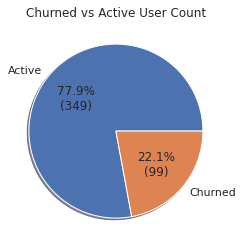

In [19]:
def my_fmt(x):
    """autopct formatter to display both actual value and percentage in pie chart"""
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)
                                      
# Draw Plot
plt.pie(counts, labels = labels, autopct = my_fmt, shadow=True)
plt.title("Churned vs Active User Count")
plt.savefig("./plots/churn_count.png")
plt.show()

## User Life Time 

We define the __life time__ of a user as the number of days past since a user's registration time and the last time a user's activity was logged.

In [20]:
def get_life_time(df=df):
    """
    Returns the number of days since registration for each user
    """

    life_time_df = df.groupby("userId").agg(
        F.expr("from_unixtime(min(registration)/1000)").alias("reg_time"),
        F.expr("from_unixtime(max(ts)/1000)").alias("last_active_time"),
    )

    return life_time_df.withColumn(
        "life_time", F.datediff(F.col("last_active_time"), F.col("reg_time"))
    ).select("userId", "life_time")

Define two helper functions that generate distribution plot and box plot for visualizing the differences between churned and active users on different metrics.

In [21]:
def dist_plot(plot_df, title):
    """
    Plot the distribution of specific metrics per active vs. churned user
    
    Output plot impage is saved as .PNG file to the /plots folder
    """
    
    
    active_data = plot_df[plot_df["churn"]==0].iloc[:,2]
    churn_data = plot_df[plot_df["churn"]==1].iloc[:,2]
    
    f, axes = plt.subplots(1,2,figsize=(12.8,4.8), dpi=80)
    sns.distplot(
        active_data,
        kde=False,
        label="Active",
        ax=axes[0]
    )
    sns.distplot(
        churn_data,
        kde=False,
        label="Churned",
        ax=axes[0]
    )
    sns.distplot(
        active_data,
        kde=True,
        label="Active",
        ax=axes[1]
    )
    sns.distplot(
        churn_data,
        kde=True,
        label="Churned",
        ax=axes[1]
    )
    axes[0].set_title("Absolute Count")
    axes[1].set_title("Gaussian Kernel Density Estimate")
    axes[0].set_xlabel("")
    axes[1].set_xlabel("")
    axes[1].legend()
    f.text(0.5, 0.01, title, ha='center')
    f.savefig(f"./plots/{title} Dist Plot.png")

In [22]:
def box_plot(plot_df, title):
    """
    Creates boxplot of specific metrics by active vsed churned users
    
    Output plot impage is saved as .PNG file to the /plots folder
    """

    x = plot_df.columns.tolist()[1]
    y = plot_df.columns.tolist()[2]
    ax = sns.boxplot(x=x, y=y, data=plot_df)
    ax.set(xlabel="", ylabel="", xticklabels=["Active", "Churn"], title=title)
    fig = ax.get_figure()
    fig.savefig(f"./plots/{title} Box Plot.png")

In [23]:
# Data preparation
life_time_df = get_life_time(df)
life_time_pd_df = churn_df.join(life_time_df, on=["userId"], how="left").na.fill(0).toPandas()
life_time_pd_df.iloc[:, 1:].groupby("churn").describe()

life_time                                                     
          count       mean        std  min   25%   50%    75%    max
churn                                                               
0         349.0  86.977077  38.705706  1.0  63.0  77.0  102.0  391.0
1          99.0  67.969697  43.570598 -1.0  41.0  60.0   90.0  264.0

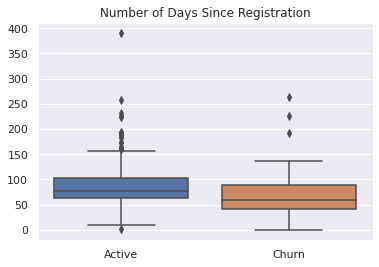

In [24]:
box_plot(life_time_pd_df, "Number of Days Since Registration")

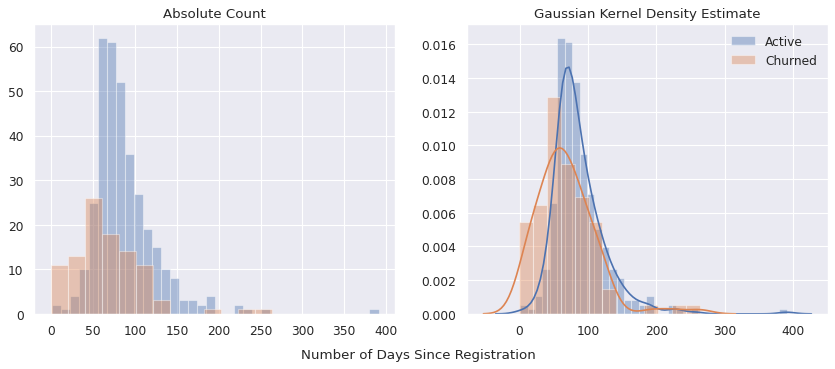

In [25]:
dist_plot(life_time_pd_df, "Number of Days Since Registration");

**Observation**

Churned users have shorter __life time__ compared to that of the active users.

## Recent Inactive Days

The `recent inactive days` is defined as the time(# of days) difference between the earliest and latest time stamp for each user.  

In [26]:
def get_inactive_days(df=df):
    """
    Returns the number of days past since each user's last active session.
    """

    df.createOrReplaceTempView("df")
    
    # for churned user, find the session timestamp for when `Cancellation Confirmation`
    # took place and the timestamp for previous session
    churned_df = spark.sql(
        """
        WITH T as (
            SELECT userId, sessionId, MAX(ts) as max_session_ts
            FROM df
            WHERE userId IN (SELECT DISTINCT userId from df WHERE page = "Cancellation Confirmation"
            )
            GROUP BY userId, sessionId
            ORDER BY userId, sessionId
        )

        SELECT a1.userId, last_session_ts, max(b.max_session_ts) AS second_last_session_ts
        FROM
        (SELECT userId, MAX(max_session_ts) as last_session_ts
        FROM T as a
        GROUP BY userId) a1
        JOIN T as b
        ON b.userID = a1.userId AND b.max_session_ts != a1.last_session_ts
        GROUP BY a1.userId, a1.last_session_ts
        """
    )

    # for active user, find the last session timestamp and the global maxtime stamp 
    active_df = spark.sql(
        """
        WITH T as (
            SELECT userId, sessionId, MAX(ts) as max_session_ts
            FROM df
            WHERE userId NOT IN (SELECT DISTINCT userId from df WHERE page = "Cancellation Confirmation"
            )
            GROUP BY userId, sessionId
            ORDER BY userId, sessionId
        )

        SELECT userID, last_session_ts, second_last_session_ts FROM
        (SELECT userID, MAX(max_session_ts) as second_last_session_ts FROM T GROUP BY userID) as u_max
        CROSS JOIN
        (SELECT MAX(max_session_ts) as last_session_ts from T) 
        """
    )

    combined_df = churned_df.union(active_df)

    return combined_df.withColumn(
        "recent_inactive_days",
        F.datediff(
            F.from_unixtime(F.col("last_session_ts") / 1000),
            F.from_unixtime(F.col("second_last_session_ts") / 1000),
        ),
    ).select("userId", "recent_inactive_days")

In [27]:
# Data preparation
inactive_days_df = get_inactive_days(df)
inactive_days_pd_df= (
    churn_df.join(inactive_days_df, on=["userId"], how="left").na.fill(0).toPandas()
)
inactive_days_pd_df.iloc[:, 1:].groupby("churn").describe()

recent_inactive_days                                                
                     count      mean        std  min  25%  50%   75%   max
churn                                                                     
0                    349.0  7.532951  10.523492  0.0  1.0  3.0  10.0  60.0
1                     99.0  3.878788   5.980022  0.0  1.0  1.0   5.0  35.0

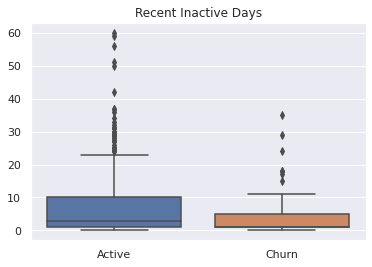

In [28]:
box_plot(inactive_days_pd_df, "Recent Inactive Days")

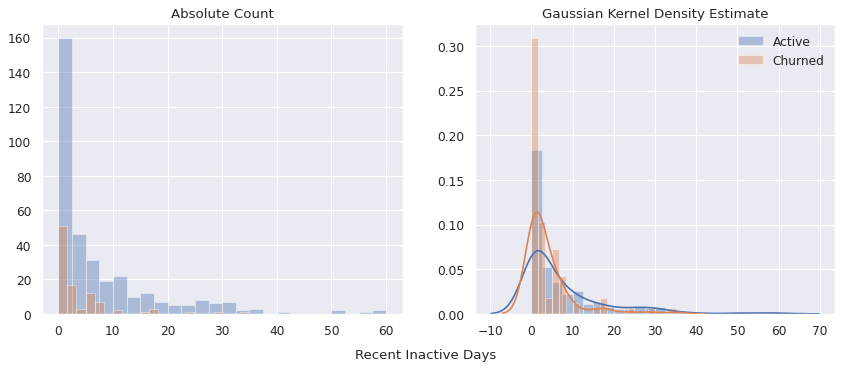

In [29]:
dist_plot(inactive_days_pd_df, "Recent Inactive Days")

## Number of Unique Sessions

Count the number of __unique sessions__ logged by each user.

In [30]:
def get_session_count(df=df):
    """Returns the count of distinct sessionId for each user """
    
    session_df = df.groupby("userId").agg(F.expr("count(distinct(sessionId))").alias("num_unique_sessions"))
    return session_df

In [31]:
session_df = get_session_count(df)
# Join the the session count with the churn df
session_pd_df = churn_df.join(session_df,on=["userId"], how = "left").na.fill(0).toPandas()
# Stats/distribution of unique session counts by user type
session_pd_df.iloc[:,1:].groupby("churn").describe()

num_unique_sessions                                                  
                    count       mean        std  min  25%   50%   75%   max
churn                                                                      
0                   349.0  13.991404  13.293652  1.0  5.0  10.0  19.0  92.0
1                    99.0  12.090909  12.683825  1.0  4.0   8.0  16.0  69.0

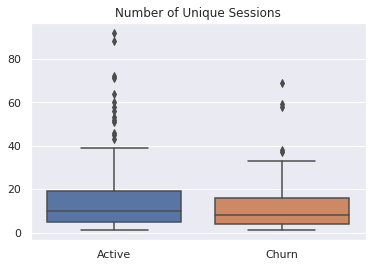

In [32]:
box_plot(session_pd_df, "Number of Unique Sessions")

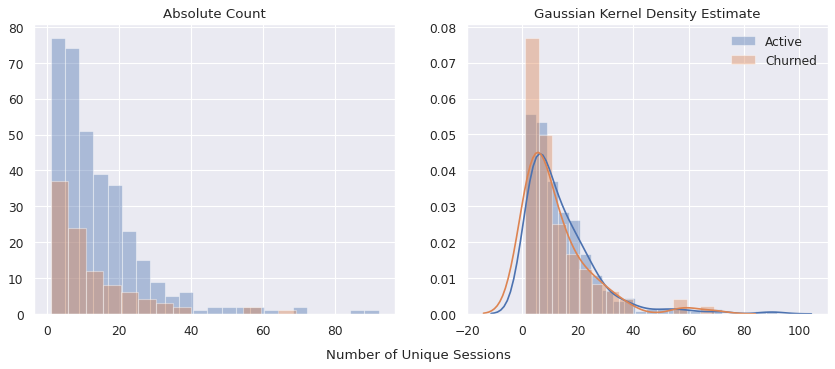

In [33]:
dist_plot(session_pd_df, "Number of Unique Sessions")

## User Gender

In [34]:
def get_gender(df = df):
    """
    Query and return the gender of each user
    """ 
    gender_udf = F.udf(lambda x: 0 if x=='F' else 1, T.IntegerType())
    gender_df = df.groupby("userId").agg(F.max("gender").alias('gender'))
    gender_df = gender_df.withColumn('gender', gender_udf(gender_df['gender']))
    
    return gender_df

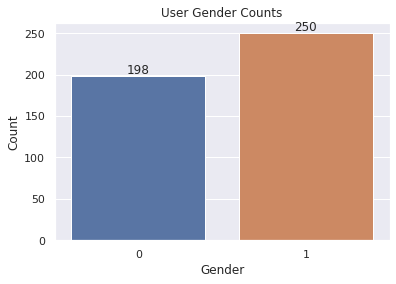

In [35]:
# create gender by userId dataframe
gender_df=get_gender(df)
# create gender counts df
data = gender_df.groupby("gender").agg(F.expr("count(userId)").alias("count")).toPandas()

# Plot gender counts df
ax = sns.barplot(x = "gender", y = "count", data = data)
# Annotations
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        height + 3,
        "{:.0f}".format(height),
        ha="center",
    )
plt.title("User Gender Counts")
plt.xlabel("Gender")
plt.ylabel("Count");

User Gender by Churn

In [36]:
data = gender_df.join(churn_df, on=["userId"]).toPandas()
data['churn'] = data['churn'].map({0:"Active", 1:"Churn"})

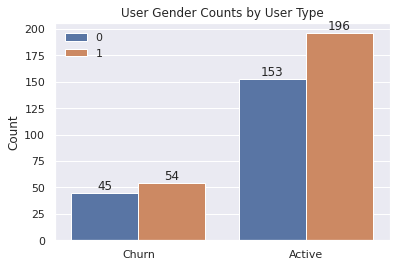

In [37]:
ax = sns.countplot(x="churn", hue="gender", data=data)
ax.legend().set_title("")

# Annotations
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        height + 3,
        "{:.0f}".format(height),
        ha="center",
    )
plt.title("User Gender Counts by User Type")
plt.xlabel("")
plt.ylabel("Count");
plt.savefig("./plots/Gender_Plot.png")

## Average Number of Songs Listened Per Session

In [38]:
def get_songs_per_session(df=df):
    """calculates the average number of songs played per session for each user"""

    songs_per_session_df = df.groupby("userId").agg(
        F.expr("COUNT(song)/COUNT(DISTINCT(sessionId))").alias("songs_per_session")
    )
    return songs_per_session_df

In [39]:
song_count_df =get_songs_per_session(df)
# Join the the session count with the churn df
song_count_pd_df= churn_df.join(song_count_df,on=["userId"], how = "left").na.fill(0).toPandas()
# Stats/distribution of unique session counts by user type
song_count_pd_df.iloc[:,1:].groupby("churn").describe()

songs_per_session                                              \
                  count       mean        std  min        25%   50%   
churn                                                                 
0                 349.0  62.412305  35.444597  1.0  33.000000  59.0   
1                  99.0  69.858025  49.532063  7.0  36.482759  62.0   

                         
             75%    max  
churn                    
0      88.153846  209.6  
1      82.513158  360.0

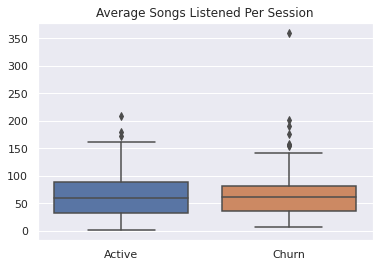

In [40]:
box_plot(song_count_pd_df, "Average Songs Listened Per Session")

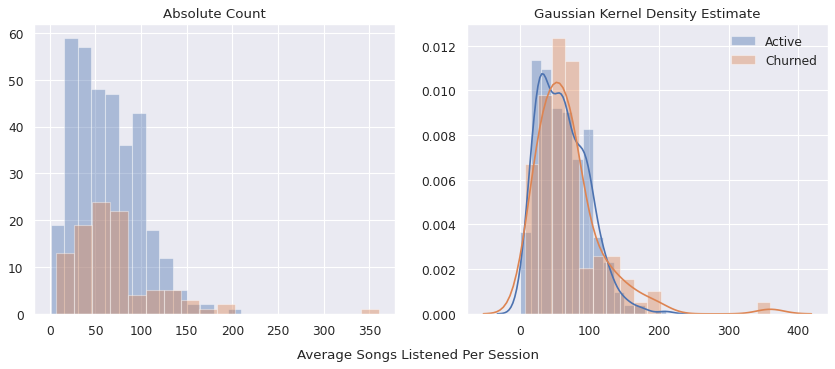

In [41]:
dist_plot(song_count_pd_df, "Average Songs Listened Per Session")

__Observation__:

Active users tend to be listening to more songs in each login session.

## Average Song Length

In [42]:
def get_avg_song_length(df=df):
    """calculates the average length of song listened to by each user"""
    return df.groupby("userId").agg(F.expr("AVG(length)").alias("avg_song_length"))

In [43]:
# data preparation for plot
song_length_df =get_avg_song_length(df)
song_length_pd_df= churn_df.join(song_length_df,on=["userId"], how = "left").na.fill(0).toPandas()
song_length_pd_df.iloc[:,1:].groupby("churn").describe()

avg_song_length                                                \
                count        mean       std         min         25%   
churn                                                                 
0               349.0  248.149499  9.752802  131.003630  245.290129   
1                99.0  248.405083  6.102903  231.112583  245.896733   

                                           
              50%         75%         max  
churn                                      
0      248.319460  250.859188  320.812244  
1      248.472512  251.528956  269.489070

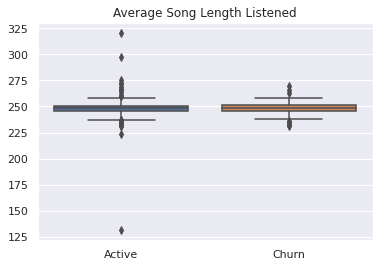

In [44]:
box_plot(song_length_pd_df, "Average Song Length Listened")

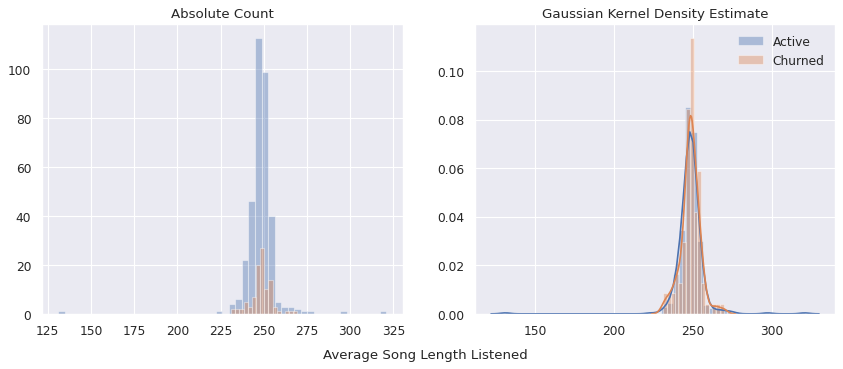

In [45]:
dist_plot(song_length_pd_df, "Average Song Length Listened")

__Observation:__

Surprisingly, the churned user actually experienced less 404 connection errors on average compared to the active users.

## Page Visited 

The `page` column contains information on the page visited or functions used by each user. In this session, we will investigate how churned and active users 

In [46]:
action_list = df.select("page").distinct().toPandas().iloc[:,0]

Exam the statistics of each of the `page` visited by users and see if there is any difference trend between the `active` and `churned` users.

In [47]:
def get_user_page_count(page, alias, df=df):
    """Query and return the count of specific action by each user"""

    return (
        df.select("userId", "page")
        .filter("page = '{}'".format(page))
        .groupby("userId")
        .agg(F.expr("count(page)").alias(alias))
    )

In [48]:
# print the stats of the frequency of each page visited by two groups of user (churned vs active)

pages = df.select("page").distinct().rdd.flatMap(lambda x: x).collect()

for page in pages:
    page_df = get_user_page_count(page, page, df)
    churn_page = churn_df.join(page_df, on=["userId"],how='left').na.fill(0).toPandas()
    print(churn_page.iloc[:,1:].groupby("churn").describe().unstack().unstack())

churn             0     1
Cancel count  349.0  99.0
       mean     0.0   1.0
       std      0.0   0.0
       min      0.0   1.0
       25%      0.0   1.0
       50%      0.0   1.0
       75%      0.0   1.0
       max      0.0   1.0
churn                            0          1
Submit Downgrade count  349.000000  99.000000
                 mean     0.252149   0.292929
                 std      0.508013   0.626824
                 min      0.000000   0.000000
                 25%      0.000000   0.000000
                 50%      0.000000   0.000000
                 75%      0.000000   0.000000
                 max      2.000000   3.000000
churn                       0          1
Thumbs Down count  349.000000  99.000000
            mean    10.759312  11.676768
            std     12.801511  15.202597
            min      0.000000   0.000000
            25%      2.000000   2.000000
            50%      6.000000   7.000000
            75%     16.000000  15.000000
            max     80.0

**Observation**

The active user tend to have higher count on almost all the different pages visited except for the `Roll Advert` page than the churned users. This observation is expected because active users generally have longer user life time and higher unique sessions logged, thus they are likely to use all features and visited all pages on Sparkify in absolute counts when compared to that of the churned users.

We might be able to draw more insights from the `page` column if we look at the page count normalized in some way (i.e. per session or per day)

### Page Visited Normalized by Sessions

In [49]:
def get_page_count_per_session(page, df=df):
    """Query and return the count of specific page visited by each user per session"""

    session_count = get_session_count(df)
    page_count = get_user_page_count(page,page, df)
    output_df = session_count.join(page_count, on=["userId"], how="left").na.fill(0)
    output_df = output_df.withColumn(
        f"{page} Per Session", F.col(page) / F.col("num_unique_sessions")
    )

    return output_df.select(output_df.columns[0], output_df.columns[-1])

In [50]:
get_page_count_per_session("Cancel",df).show()

+------+--------------------+
|userId|  Cancel Per Session|
+------+--------------------+
|100010|                 0.5|
|200002|                 0.2|
|   296|                 0.2|
|   125|                 0.0|
|   124|0.058823529411764705|
|    51|                 0.2|
|     7|                 0.0|
|200037| 0.14285714285714285|
|   169|                 0.0|
|   205|                 0.0|
|   272|                 0.0|
|    15|                 0.0|
|   232|                 0.0|
|   234|0.038461538461538464|
|   282|                 0.0|
|    54|               0.125|
|   155|                 0.0|
|200043|                 0.0|
|100014|                0.25|
|   132|                 0.5|
+------+--------------------+
only showing top 20 rows



Print the descriptive stastics on the count of pages visited per session for churned and active users. 

In [51]:
# print the descriptive statsof the frequency of each page visited by two groups of user (churned vs active)
pages = df.select("page").distinct().rdd.flatMap(lambda x: x).collect()

for page in pages:
    page_df = get_page_count_per_session(page, df)
    churn_page = churn_df.join(page_df, on=["userId"],how='left').na.fill(0).toPandas()
    print(churn_page.iloc[:,1:].groupby("churn").describe().unstack().unstack())

churn                         0          1
Cancel Per Session count  349.0  99.000000
                   mean     0.0   0.239023
                   std      0.0   0.278162
                   min      0.0   0.014493
                   25%      0.0   0.062500
                   50%      0.0   0.125000
                   75%      0.0   0.250000
                   max      0.0   1.000000
churn                                        0          1
Submit Downgrade Per Session count  349.000000  99.000000
                             mean     0.020193   0.020123
                             std      0.055244   0.060857
                             min      0.000000   0.000000
                             25%      0.000000   0.000000
                             50%      0.000000   0.000000
                             75%      0.000000   0.000000
                             max      0.500000   0.500000
churn                                   0          1
Thumbs Down Per Session count  349.000

### Visualization of Page Visited per Session

/home/roger/anaconda3/envs/sparkify/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/roger/anaconda3/envs/sparkify/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


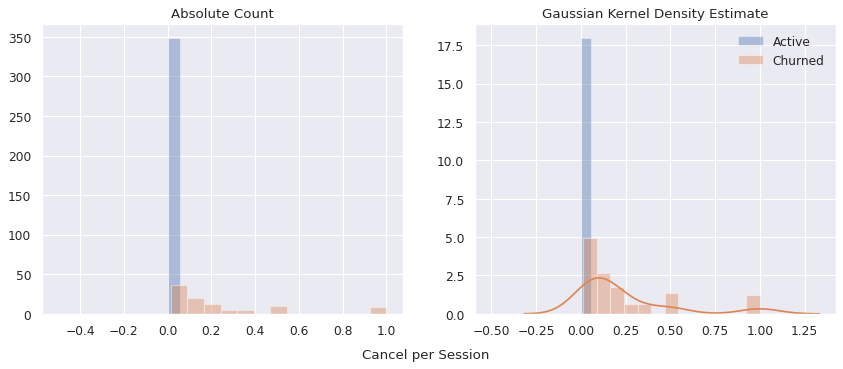

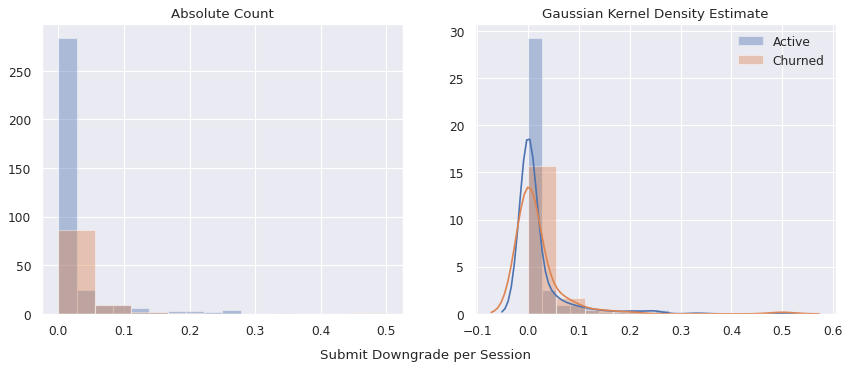

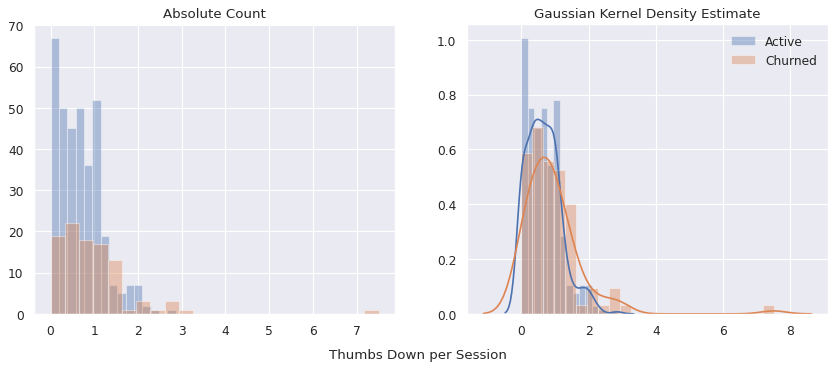

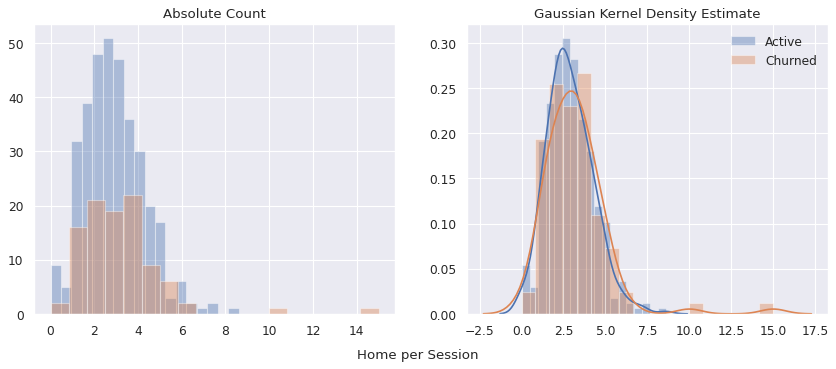

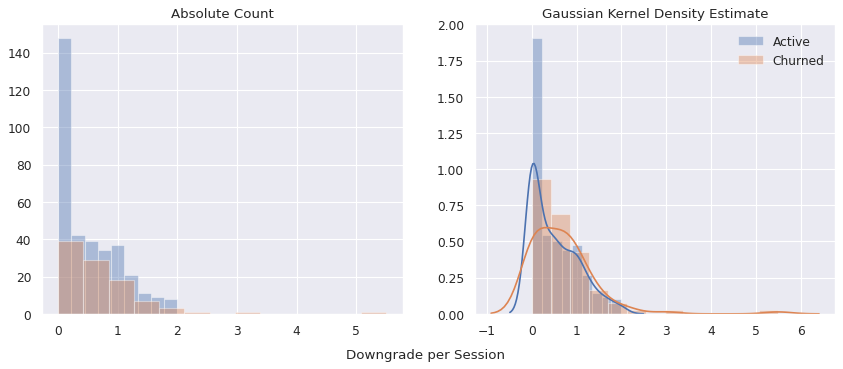

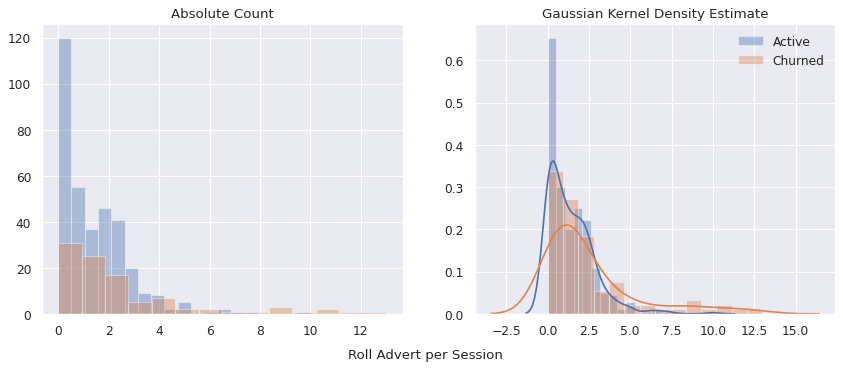

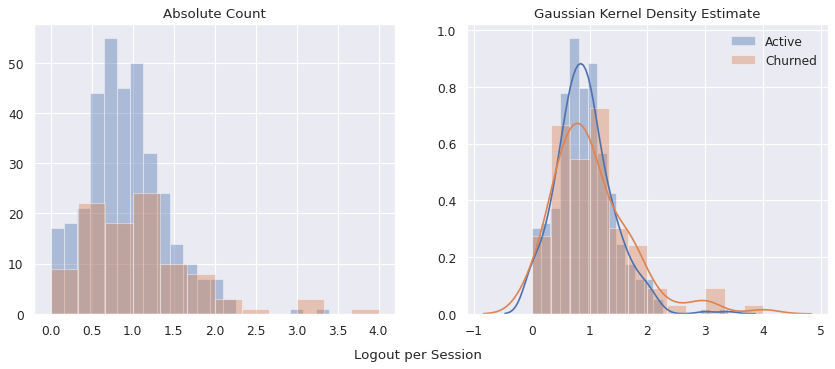

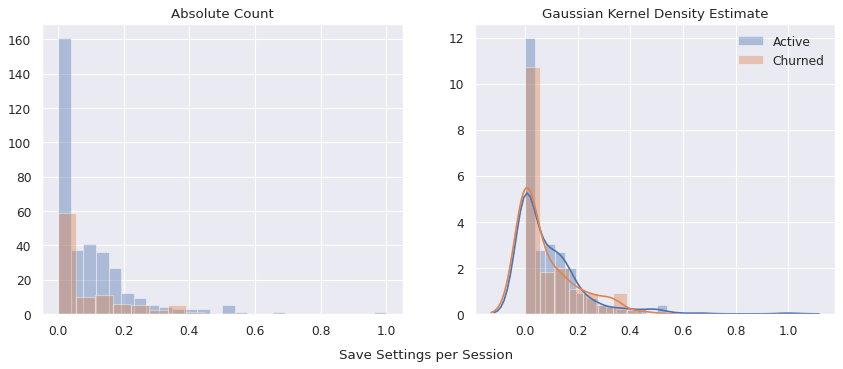

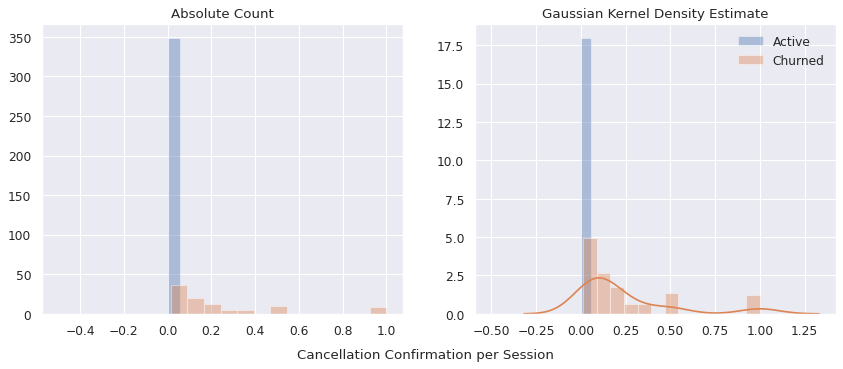

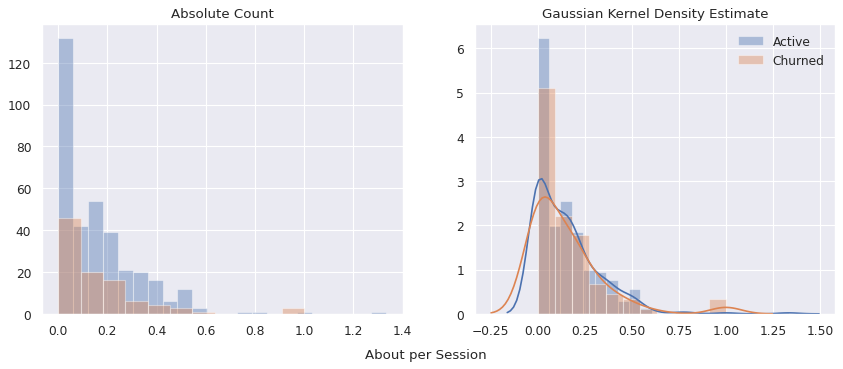

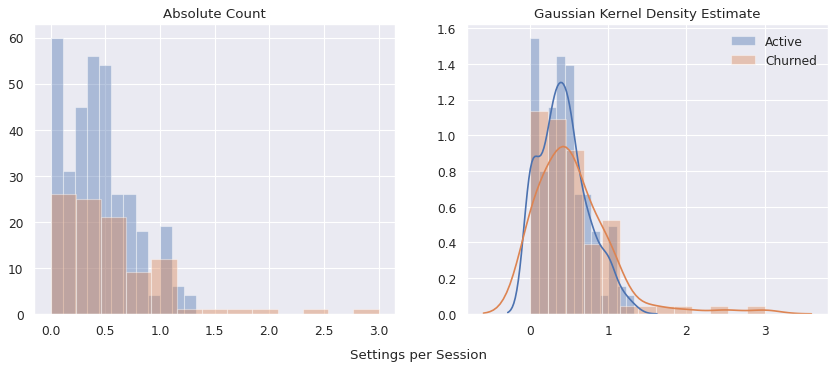

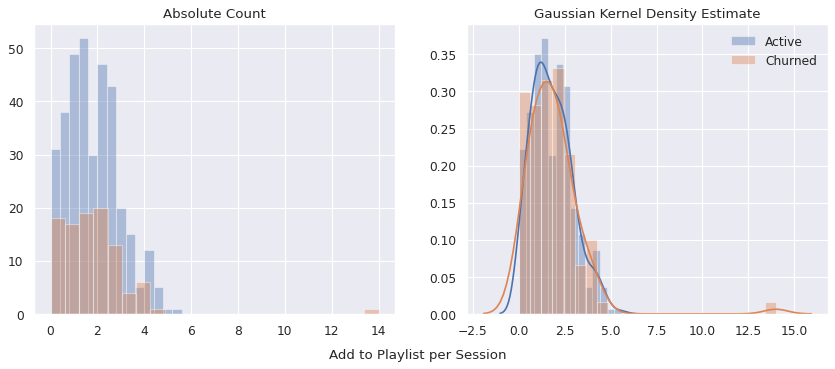

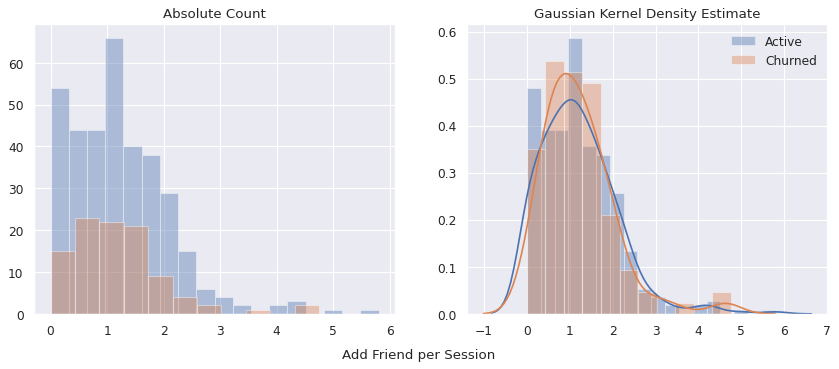

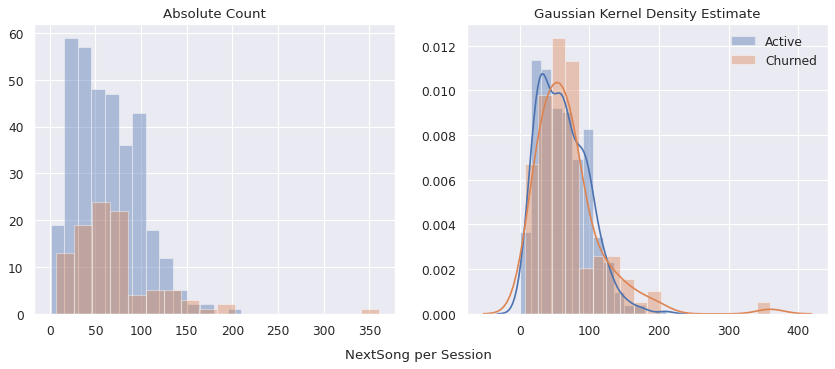

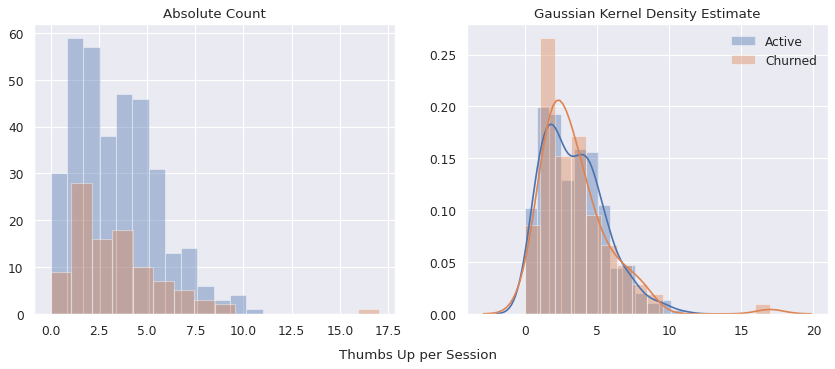

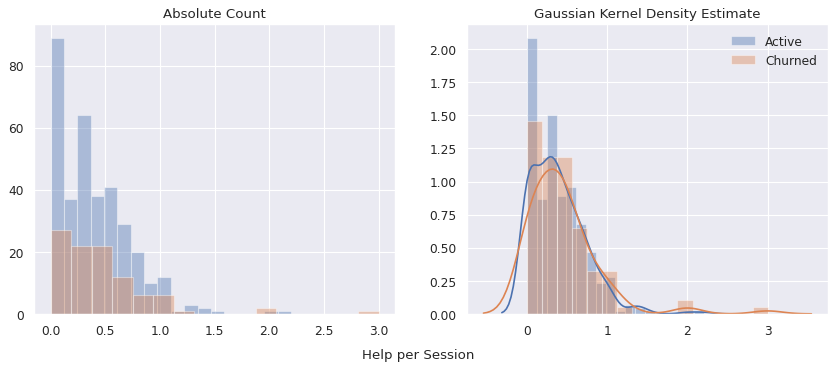

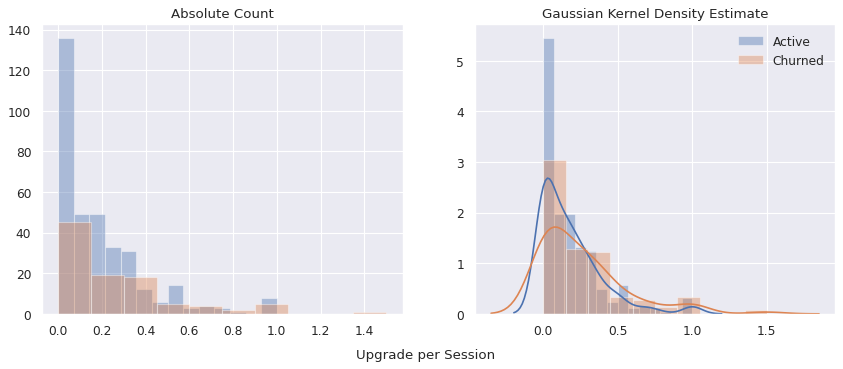

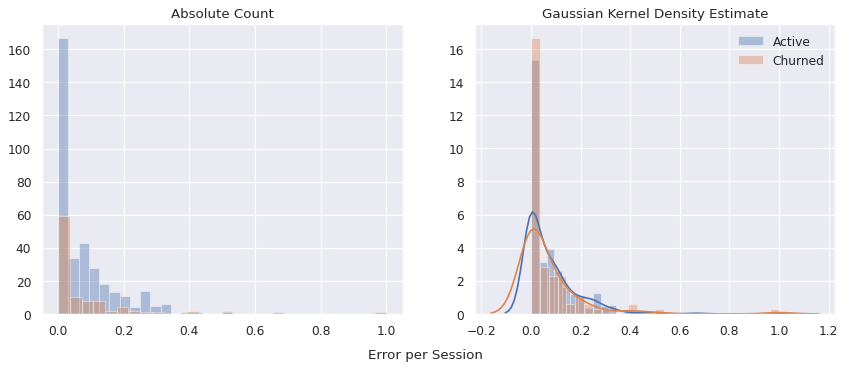

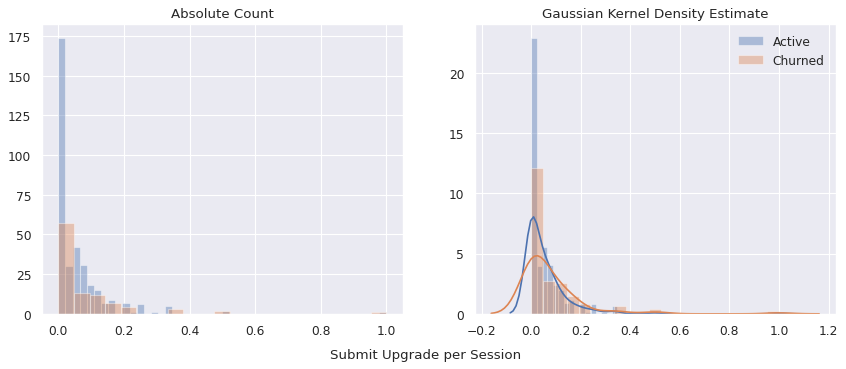

In [52]:
for page in pages:
    plot_df = churn_df.join(get_page_count_per_session(page), on=["userId"], how = "left").na.fill(0).toPandas()
    dist_plot(plot_df, f"{page} per Session");

# Feature Engineering

In [53]:
def feat_engineer(df,output_file_path):
    """
    Join selected feature columns by userId and save the output 
    dataframe in parquet format    
    """
    
    # remove data where userID is empty string
    df = df.filter("userId != ''")

    churn_df = get_churn(df)  # define churn
    lifeTime_df = get_life_time(df)  # days since registration
    recentInactiveDays_df = get_inactive_days(df)  # days since last active
    sessionCount_df = get_session_count(df)  # number of unique sessions
    gender_df = get_gender(df)  # gender
    songsPerSession_df = get_songs_per_session(df)  # number of songs per session
    avgSongLength_df = get_avg_song_length(df)  # average length of song listened

    # average count of page visited per session
    thumbsDown_per_session_df = get_page_count_per_session("Thumbs Down", df)
    thumbsUp_per_session_df = get_page_count_per_session("Thumbs Up", df)
    home_per_session_df = get_page_count_per_session("Home", df)
    about_per_session_df = get_page_count_per_session("About", df)
    settings_per_session_df = get_page_count_per_session("Settings", df)
    addPlay_list_per_session_df = get_page_count_per_session("Add to Playlist", df)
    addFriend_per_session_df = get_page_count_per_session("Add Friend", df)
    nextSong_per_session_df = get_page_count_per_session("NextSong", df)
    error_per_session_df = get_page_count_per_session("Error", df)

    # join the feature columns above together
    output_df = (
        churn_df.join(lifeTime_df, "userId", "left")
        .join(recentInactiveDays_df, "userId", "left")
        .join(sessionCount_df, "userId", "left")
        .join(gender_df, "userId", "left")
        .join(songsPerSession_df, "userId", "left")
        .join(avgSongLength_df, "userId", "left")
        .join(thumbsDown_per_session_df, "userId", "left")
        .join(thumbsUp_per_session_df, "userId", "left")
        .join(home_per_session_df, "userId", "left")
        .join(about_per_session_df, "userId", "left")
        .join(settings_per_session_df, "userId", "left")
        .join(addPlay_list_per_session_df, "userId", "left")
        .join(addFriend_per_session_df, "userId", "left")
#         .join(nextSong_per_session_df, "userId", "left")
        .join(error_per_session_df, "userId", "left")
    ).na.fill(0)
    # rename columnes: replace white space with underscore, lower cases
    new_column_name_list = list(
        map(lambda x: x.replace(" ", "_").lower(), output_df.columns)
    )
    output_df = output_df.toDF(*new_column_name_list)
    # save output
    output_df.write.mode("overwrite").parquet(output_file_path)

In [54]:
input_file_path = "./medium-sparkify-event-data.json"
df = spark.read.json(input_file_path)
output_file_path= "./df_parquet"
feat_engineer(df,output_file_path)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## Setups

In [55]:
# Load Data
parquet_uri = "./df_parquet"
data = spark.read.parquet(parquet_uri)

In [56]:
# transform data for machine learning 
cols =data.columns[2:]
df_assembler = VectorAssembler(inputCols = cols, outputCol="features")
ml_df = df_assembler.transform(data)

In [57]:
## Split train and test data 75-25
model_df =ml_df.select(F.col("features"), F.col("churn").alias("label"))
train_df, test_df = model_df.randomSplit([0.75, 0.25], seed=95130)

In [58]:
train_df.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   75|
|    0|  247|
+-----+-----+



In [59]:
test_df.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   24|
|    0|  102|
+-----+-----+



In [60]:
model_df.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   99|
|    0|  349|
+-----+-----+



## Logistic Regression

__Train Model__

In [61]:
%%time
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=100)
lrModel = lr.fit(train_df)

CPU times: user 18 ms, sys: 0 ns, total: 18 ms
Wall time: 5.03 s


Plot the `ROC` and `AUC`

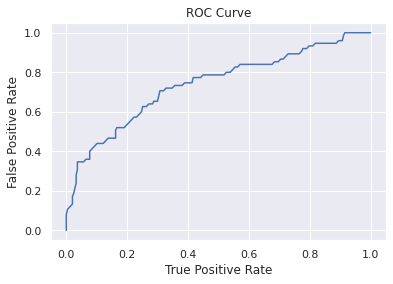

TrainSet AUC: 0.7380026990553306


In [62]:
trainSet = lrModel.summary
roc = trainSet.roc.toPandas()
plt.plot(roc["FPR"],roc["TPR"])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()
print("TrainSet AUC: " + str(trainSet.areaUnderROC))

Precision and recall

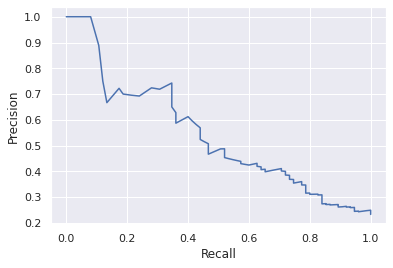

In [63]:
pr = trainSet.pr.toPandas()
plt.plot(pr["recall"],pr["precision"])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

__Make Predictions__

In [64]:
predictions = lrModel.transform(test_df)
predictions.select("features", "probability", "prediction", "label").show()

+--------------------+--------------------+----------+-----+
|            features|         probability|prediction|label|
+--------------------+--------------------+----------+-----+
|[52.0,10.0,5.0,0....|[0.81957375930142...|       0.0|    0|
|[65.0,4.0,18.0,0....|[0.79866866249270...|       0.0|    0|
|[68.0,2.0,33.0,0....|[0.79153905096024...|       0.0|    0|
|[71.0,0.0,6.0,0.0...|[0.75483885721528...|       0.0|    0|
|[81.0,0.0,23.0,1....|[0.73850390250419...|       0.0|    1|
|[86.0,6.0,9.0,1.0...|[0.93765001646587...|       0.0|    0|
|[86.0,7.0,22.0,1....|[0.92798095312413...|       0.0|    0|
|[92.0,0.0,39.0,1....|[0.90589313313917...|       0.0|    0|
|[92.0,4.0,12.0,1....|[0.56705002415665...|       0.0|    0|
|[96.0,1.0,15.0,1....|[0.84506650692007...|       0.0|    0|
|(14,[0,1,2,3,4,5,...|[0.98970394692563...|       0.0|    0|
|(14,[0,1,2,3,4,5,...|[0.97519609282589...|       0.0|    0|
|[36.0,0.0,1.0,1.0...|[0.03112285433557...|       1.0|    1|
|[36.0,1.0,26.0,1....|[0

__Model Performance__

In [65]:
def prediction_metrics(classifier, test_df):
    """
    Display the accuracy, precision, recall, f1, and AUC for classifier's prediction
    performance on the testing data
    """
    predictions = classifier.transform(test_df)

    accuracy = MulticlassClassificationEvaluator(metricName="accuracy").evaluate(
        predictions
    )
    precision = MulticlassClassificationEvaluator(
        metricName="weightedPrecision"
    ).evaluate(predictions)
    recall = MulticlassClassificationEvaluator(metricName="weightedRecall").evaluate(
        predictions
    )
    f1 = MulticlassClassificationEvaluator(metricName="f1").evaluate(predictions)
    AUC = BinaryClassificationEvaluator().evaluate(predictions)

    return{"accuracy": accuracy,
          "precision": precision,
          "recall": recall,
          "f1": f1,
          "AUC": AUC}

In [66]:
for k,v in prediction_metrics(lrModel, test_df).items():
    print(f"{k}:{round(v,4)}")

accuracy:0.8333
precision:0.8163
recall:0.8333
f1:0.794
AUC:0.797


## Random Forest

__Train Model__

In [67]:
rf= RandomForestClassifier(seed=95130)
rf_classifier= rf.fit(train_df)
rf_predictions = rf_classifier.transform(test_df)
for k,v in prediction_metrics(rf_classifier, test_df).items():
    print(f"{k}: {round(v,4)}")

accuracy: 0.881
precision: 0.8962
recall: 0.881
f1: 0.858
AUC: 0.8051


__Make Predictions__

In [68]:
rf_predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[52.0,10.0,5.0,0....|    0|[17.4628390517646...|[0.87314195258823...|       0.0|
|[65.0,4.0,18.0,0....|    0|[15.8147732348568...|[0.79073866174284...|       0.0|
|[68.0,2.0,33.0,0....|    0|[16.5460969449029...|[0.82730484724514...|       0.0|
|[71.0,0.0,6.0,0.0...|    0|[17.0783525585334...|[0.85391762792667...|       0.0|
|[81.0,0.0,23.0,1....|    1|[18.1486918033342...|[0.90743459016671...|       0.0|
|[86.0,6.0,9.0,1.0...|    0|[17.5201329569753...|[0.87600664784876...|       0.0|
|[86.0,7.0,22.0,1....|    0|[17.6928195318248...|[0.88464097659124...|       0.0|
|[92.0,0.0,39.0,1....|    0|[17.8040869654618...|[0.89020434827309...|       0.0|
|[92.0,4.0,12.0,1....|    0|[14.9615220342425...|[0.74807610171212...|       0.0|
|[96.0,1.0,15.0,

__Model Performance__

In [69]:
for k,v in prediction_metrics(rf_classifier, test_df).items():
    print(f"{k}: {round(v,4)}")

accuracy: 0.881
precision: 0.8962
recall: 0.881
f1: 0.858
AUC: 0.8051


__Feature Importance__

## Decision Tree

__Train Model__

In [70]:
%%time
dt_classifier = DecisionTreeClassifier().fit(train_df)

CPU times: user 9.23 ms, sys: 3.8 ms, total: 13 ms
Wall time: 705 ms


__Make Predictions__

In [71]:
dt_predictions = dt_classifier.transform(test_df)
dt_predictions.show()

+--------------------+-----+-------------+--------------------+----------+
|            features|label|rawPrediction|         probability|prediction|
+--------------------+-----+-------------+--------------------+----------+
|[52.0,10.0,5.0,0....|    0|   [35.0,2.0]|[0.94594594594594...|       0.0|
|[65.0,4.0,18.0,0....|    0| [185.0,28.0]|[0.86854460093896...|       0.0|
|[68.0,2.0,33.0,0....|    0| [185.0,28.0]|[0.86854460093896...|       0.0|
|[71.0,0.0,6.0,0.0...|    0| [185.0,28.0]|[0.86854460093896...|       0.0|
|[81.0,0.0,23.0,1....|    1| [185.0,28.0]|[0.86854460093896...|       0.0|
|[86.0,6.0,9.0,1.0...|    0| [185.0,28.0]|[0.86854460093896...|       0.0|
|[86.0,7.0,22.0,1....|    0| [185.0,28.0]|[0.86854460093896...|       0.0|
|[92.0,0.0,39.0,1....|    0| [185.0,28.0]|[0.86854460093896...|       0.0|
|[92.0,4.0,12.0,1....|    0| [185.0,28.0]|[0.86854460093896...|       0.0|
|[96.0,1.0,15.0,1....|    0| [185.0,28.0]|[0.86854460093896...|       0.0|
|(14,[0,1,2,3,4,5,...|   

__Model Performance__

In [72]:
for k,v in prediction_metrics(dt_classifier, test_df).items():
    print(f"{k}: {round(v,4)}")

accuracy: 0.8413
precision: 0.8285
recall: 0.8413
f1: 0.8322
AUC: 0.3352


## Gradient-Boosted Tree

__Train Model__

In [73]:
%%time
gbt = GBTClassifier(seed=95130)
gbt_classifier= gbt.fit(train_df)

CPU times: user 13.2 ms, sys: 3.91 ms, total: 17.1 ms
Wall time: 5.75 s


__Make Predictions__

In [74]:
gbt_predictions = gbt_classifier.transform(test_df)
gbt_predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[52.0,10.0,5.0,0....|    0|[1.49268896256306...|[0.95190916171400...|       0.0|
|[65.0,4.0,18.0,0....|    0|[1.38133340407119...|[0.94062474993622...|       0.0|
|[68.0,2.0,33.0,0....|    0|[1.57937932053152...|[0.95925245285495...|       0.0|
|[71.0,0.0,6.0,0.0...|    0|[1.20001664875235...|[0.91682984257202...|       0.0|
|[81.0,0.0,23.0,1....|    1|[1.14571758221325...|[0.90816521457912...|       0.0|
|[86.0,6.0,9.0,1.0...|    0|[0.92848255462572...|[0.86494281449447...|       0.0|
|[86.0,7.0,22.0,1....|    0|[1.17422505538461...|[0.91281095524261...|       0.0|
|[92.0,0.0,39.0,1....|    0|[1.12191628851441...|[0.90411721658649...|       0.0|
|[92.0,4.0,12.0,1....|    0|[0.50002178533638...|[0.73106714505796...|       0.0|
|[96.0,1.0,15.0,

__Model Performance__

In [75]:
for k,v in prediction_metrics(gbt_classifier, test_df).items():
    print(f"{k}: {round(v,4)}")

accuracy: 0.8571
precision: 0.8448
recall: 0.8571
f1: 0.8456
AUC: 0.7226


__Observation:__

- At default setting, GBT and Random Forest performs very well considering both f1 score and AUC.
- Although Descision Tree has slightly higher f1 score, but it has terribly low AUC meaning it severely overfit the training data.
- We will perform hyper parameter tuning on the GBT and Random Forest model.

## Hyper Parameter Tuning

### GBT

In [152]:
# perform grid search to find the best parameters for GBT classifier
gbt_classifier = GBTClassifier(seed=95130)
paramGrid = (
    ParamGridBuilder()
    .addGrid(gbt_classifier.maxDepth, [5, 10])
    .addGrid(gbt_classifier.maxIter, [5, 10, 20])
    .addGrid(gbt_classifier.minInfoGain, [0, 0.01])
    .build()
)
# use F1 score as the model performance metrics
evaluator = MulticlassClassificationEvaluator(metricName="f1")
cv = CrossValidator(
    estimator=gbt_classifier,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
)

In [153]:
%%time
cvModel = cv.fit(train_df)

CPU times: user 1.54 s, sys: 322 ms, total: 1.86 s
Wall time: 2min 2s


In [154]:
for k,v in prediction_metrics(cvModel, test_df).items():
    print(f"{k}: {round(v,4)}")

accuracy: 0.8333
precision: 0.8214
recall: 0.8333
f1: 0.8256
AUC: 0.7132


In [155]:
cvModel.getEstimatorParamMaps()[ np.argmax(cvModel.avgMetrics) ]

{Param(parent='GBTClassifier_98b24d4ac934', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5,
 Param(parent='GBTClassifier_98b24d4ac934', name='maxIter', doc='max number of iterations (>= 0).'): 10,
 Param(parent='GBTClassifier_98b24d4ac934', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0}

### Random Forest

In [149]:
# perform grid search to find the best parameters for Random Forest classifier
rf = RandomForestClassifier(seed=95130)
paramGrid = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [10, 20, 25, 40])
    .addGrid(rf.maxDepth, [5, 10, 15, 20])
    .build()
)
evaluator = MulticlassClassificationEvaluator(metricName="f1")
cv = CrossValidator(
    estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=4
)

In [150]:
%%time
cvModel = cv.fit(train_df)

CPU times: user 1.62 s, sys: 401 ms, total: 2.02 s
Wall time: 40.7 s


In [151]:
for k,v in prediction_metrics(cvModel, test_df).items():
    print(f"{k}: {round(v,4)}")

accuracy: 0.881
precision: 0.8962
recall: 0.881
f1: 0.858
AUC: 0.8276


In [102]:
cvModel.getEstimatorParamMaps()[ np.argmax(cvModel.avgMetrics) ]

{Param(parent='RandomForestClassifier_f0462ba10f73', name='numTrees', doc='Number of trees to train (>= 1).'): 40,
 Param(parent='RandomForestClassifier_f0462ba10f73', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5}

__Feature Importance__

In [103]:
importances =cvModel.bestModel.featureImportances

In [104]:
importances

SparseVector(14, {0: 0.2824, 1: 0.1515, 2: 0.0605, 3: 0.0041, 4: 0.0605, 5: 0.0477, 6: 0.063, 7: 0.0568, 8: 0.0537, 9: 0.0361, 10: 0.0616, 11: 0.0462, 12: 0.055, 13: 0.021})

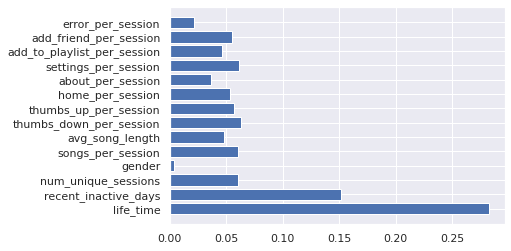

In [143]:
# Plot the feature importance
x_values = list(range(len(importances)))
# plt.subplots(figsize=(6,9))
plt.barh(x_values, importances, orientation = 'horizontal')
plt.yticks(x_values, cols);
plt.savefig("feature importances.png", bbox_inches = 'tight')

__Conclusion__:

- Random Forest performs better with a higher F1 score than GBT
- User life time and most recent inactive days contribute the most to predict churn user in the Random Forest model

#  Next Steps

Deploy the GBT classification model with best parameters to train on full data set on AWS cluster